# Семинар. Регуляризация в линейной регрессии
В этом семинаре вам предстоит обучить алгоритм линейной регрессии с двумя вариантами регуляризации:
* $L_2$-регуляризация (Ridge-регрессия)
* $L_1$-регуляризация (Lasso-регрессия).

Функция потерь для линейной регрессии с регуляризацией выглядит следующим образом:
$$L(k) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\langle w, x^i \rangle - y^i)^2 + C\cdot R(w) \rightarrow \min_{w}$$
где
* $x^i = (1, x^i_1, \ldots, x^i_n)$ --- вектор признаков $i$-ого объекта;
* $y^i \in\mathbb{R}$ --- правильный ответ на $i$-ом объекте;
* $w = (w_0, w_1, \ldots, w_n)$ --- вектор весов.

Последнее слагаемое зависит от вида регуляризации:
* В случае $L_2$-регуляризации, $R(w) = w_1^2 + \ldots + w_n^2$.
* В случае $L_1$-регуляризации, $R(w) = |w_1| + \ldots + |w_n|$.

Обратите внимание, что в обоих случаях коэффициент $w_0$ не участвует в сумме!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Lasso-регрессия
Реализуйте свой класс линейной регрессии с $L_1$-регуляризацией. Воспользуйтесь процедурой градиентного спуска.

Градиент $L_1$-регуляризованной функции потерь:
$$\nabla_{w}L = \frac{2}{\ell}\cdot X^T(Xw- y) + (0, \mathrm{sign}(w_1), \ldots, \mathrm{sign}(w_n))^T.$$

Шаг градиентного спуска:
$$w := w - \alpha \nabla_w L.$$

In [ ]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)



class MyLassoRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def regularization_term(self, weights):
        signs = np_soft_sign(weights)
        signs[0] = 0  # Не нужно регуляризовывать по свободному члену
        return signs

    def grad(self, X, y, weights):
        basic_term = 1. / X.shape[0] * (X.T @ (X @ weights - y))
        # строго говоря, градиент в 2 раза больше
        regularization_term = self.regularization_term(weights)

        return basic_term + self.C * regularization_term


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)

        # Добавляем признак из единиц
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # [ell, n]

        l, n = X.shape
        # Инициализируем веса
        weights = np.random.randn(n)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            y_pred = (X @ weights.reshape(n, 1)).ravel()  # [ell]
            grad = self.grad(X, y, weights)
            # update weights
            weights -= grad * lr / ((iter_num + 1) ** 0.5)

            # calculate loss
            loss = np.mean((X @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

Протестируем нашу функцию на одномерной регрессии.

In [ ]:
def linear_expression(x):
    return 5 * x + 6

In [ ]:
from sklearn.model_selection import train_test_split

objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [ ]:
regressor = MyLassoRegression()

losses = regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])

In [ ]:
regressor.coef_, regressor.intercept_

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.plot(X, regressor.predict(X[:, np.newaxis]))

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

## Загрузка датасета
Загрузим набор данных, с которым мы будем работать. В библиотеке scikit-learn есть множество тренировочных наборов данных для освоения и проверки методов машинного обучения. Мы будем работать с датасетом Boston. Этот датасет описывает средние цены на недвижимость в микрорайонах Бостона в $1000.
Примеры признаков микрорайона: количество преступлений на душу населения, процент старых домов в районе, среднее количество учеников на одного учителя и т.д.

![alt text](https://drive.google.com/uc?id=1uD19MPXfdXnNrvTU9rU2IO5cRlM4QfW7)

Стандартные наборы данных в scikit-learn находятся в модуле sklearn.datasets.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [ ]:
house_data = load_boston()
print(house_data['DESCR'])

### Выделение данных

Выделим матрицу объекты-признаки в переменную $X$, правильные ответы --- в переменную $y$. Используем библиотеку pandas. Для отображения информации о наборе данных используем функцию pd.describe, которая отображает полезные статистики из набора: средние значения признаков, минимум, максимум, медиану и др.

In [ ]:
X = pd.DataFrame(house_data['data'], columns=house_data['feature_names'])
y = house_data['target']

X.describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = MyLassoRegression(C=0.001)
losses = model.fit(X_train_scaled, y_train)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_train_prediction = model.predict(X_train_scaled)
y_test_prediction = model.predict(X_test_scaled)

print(f'Train MSE: {mean_squared_error(y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_prediction)}')


In [ ]:
model.coef_, model.intercept_

## Величина весов в зависимости от коэффициента регуляризации

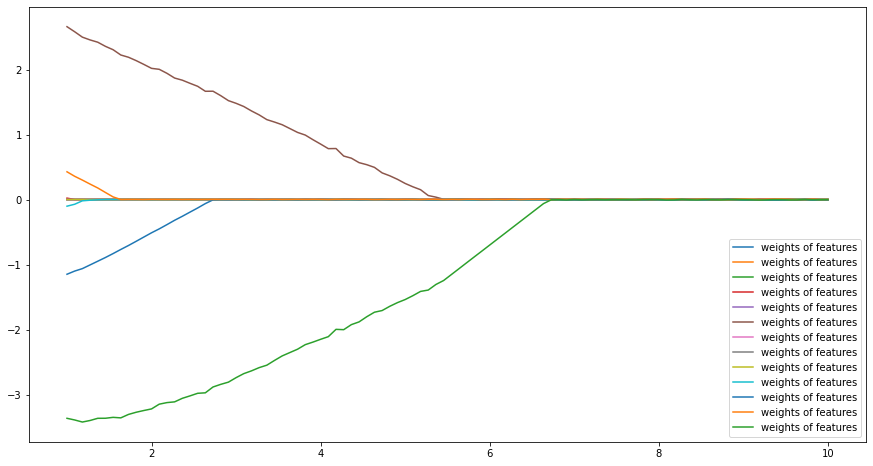

In [ ]:
reg_coefs = np.linspace(1, 10, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = MyLassoRegression(C=C)
    lasso_regressor.fit(X_train_scaled, y_train, lr=0.05, max_iter=10000)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))


plt.figure(figsize=(15,8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()

Построим такие же графики для реализации из sklearn:

In [ ]:
from sklearn.linear_model import Lasso

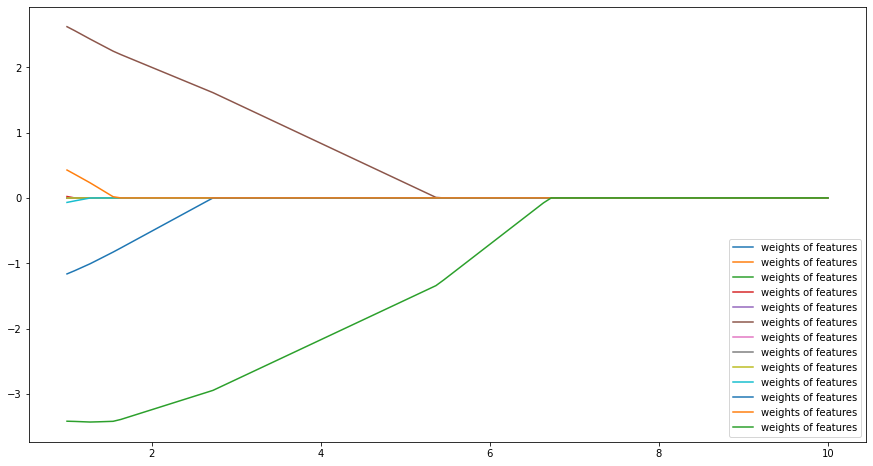

In [ ]:
reg_coefs = np.linspace(1, 10, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = Lasso(alpha=C)
    lasso_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))


plt.figure(figsize=(15,8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()

Сравнение с графиками для Ridge-регрессии:

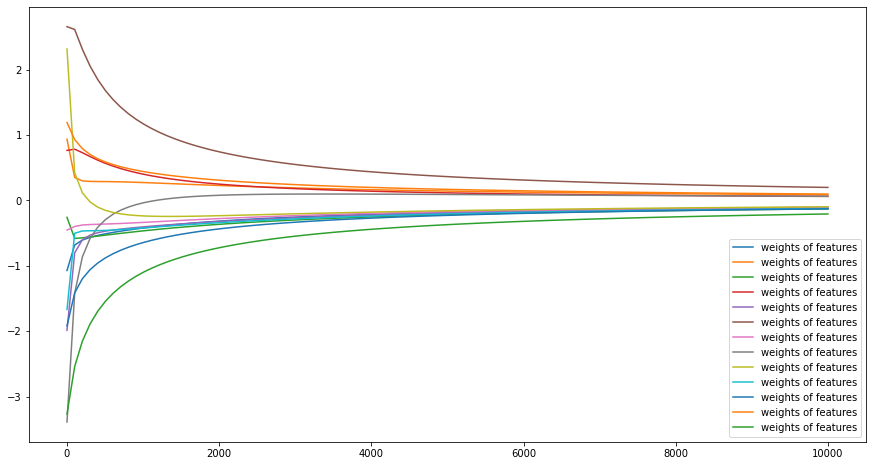

In [ ]:
from sklearn.linear_model import Ridge

reg_coefs = np.linspace(1, 10000, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    ridge_regressor = Ridge(C)
    ridge_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))


plt.figure(figsize=(15,8))
plt.plot(reg_coefs, weights.T, label='weights of features')
plt.legend()
plt.show()